<a href="https://colab.research.google.com/github/chowell2000/Election_2016/blob/master/2016_youth_vote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and data

In [84]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas as gpd
import zipfile
from google.colab import files

In [85]:
# Mounting drive to get the shapefile later

from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
# This is the exit polling data

exit_in = pd.read_csv('https://query.data.world/s/riz4gn6ykdhgvq6lkugbxijcjx3a26')

In [0]:
# Census voter participation data


voters_in = pd.read_csv('https://raw.githubusercontent.com/chowell2000/Election_2016/master/censusvotercsv.csv')

In [0]:
# Presidential election results

results_in = pd.read_csv('https://raw.githubusercontent.com/chowell2000/Election_2016/master/1976-2016-president.csv')

In [0]:
# Electoral college data

electoral = pd.read_csv('https://query.data.world/s/we45qmdo3onzzio2qu7yl3una3qzk7')

In [0]:
# Just the data including age

exit_in = exit_in[exit_in['questions'] == 'Age']

In [0]:
# Map shape data for the plots

fp = 'drive/My Drive/states_21basic/states.shp'

mapfile_df = gpd.read_file(fp)

# Data Cleaning

In [0]:
#Dropping unnecessary columns

exit_in = exit_in.drop(['url', 'questions_id', 'questions'], axis = 1)


In [0]:
# All state names to lowercase for consistency between dataframes

exit_in.state = exit_in.state.str.lower()

In [0]:
# Getting 18-24 year old data and using 18-29 where 18-24 is missing

exit_young_1 = exit_in[exit_in['options'] == '18-24'].set_index('state')
exit_young_2 = exit_in[exit_in['options'] == '18-29'].set_index('state')
exit_young = exit_young_1.combine_first(exit_young_2)

In [0]:
# Dropping Nans

exit_young =  exit_young.drop(['washington', 'oregon'])

In [0]:
# Dropping now unneeded column after we are done with it

exit_young =  exit_young.drop(['options'], axis=1)

In [0]:
# Dropping unneeded columns and state names to lowercase for consistency between dataframes

voters_in = voters_in.drop(columns=list(voters_in)[13:19]+list(voters_in)[2:3]
                             +list(voters_in)[4:9]+list(voters_in)[10:12])
voters_in.STATE = voters_in.STATE.str.lower()

In [0]:
# Rename columns something better

voters_in.columns = ['state', 'Age', 'Citizens', 'voted',
       'Percent']

In [0]:
# State names to lowercase for consistency between dataframes, and removing
#   commas from large numbers and changing back to numbers

voters_in['Citizens'] = voters_in['Citizens'].str.replace(',', '').astype(int)

voters_in['voted'] = voters_in['voted'].str.replace(',', '').astype(int)

In [0]:
# a function to calculate percentages where they are missing in the census data

def fixb(df):
  for x in df.index:
    if df['Percent'][x] == 'B':
      df['Percent'][x] = (df['voted'][x] / df['Citizens'][x])*100


In [101]:
fixb(voters_in)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
# Changing column to numbers after replacing bad data

voters_in['Percent'] = voters_in['Percent'].astype(float)

In [0]:
#Dataframe with just 18-24 votes, states as index

voters_young = voters_in[voters_in['Age'] == '18 to 24']
voters_young.set_index('state', inplace= True)

In [0]:
#Dropping unneeded columns

results_in = results_in[results_in['year'] 
                          == 2016].drop(['version','notes','state_fips','office'
                                         ,'state_cen', 'state_ic', ], axis = 1)

In [0]:
# Drop write in results

results_in = results_in[results_in['writein'] !=
                            True].drop('writein', axis = 1)


In [0]:
# Get only the results for Trump and Clinton, and all state names to lowercase
#  for consistency between dataframes

results_in = results_in[(results_in['party'] == 'republican') |
                            (results_in['party'] == 'democrat')]  
results_in.state = results_in.state.str.lower()                          

In [0]:
# The results have two lines for each state - one for each candidate.  This
#   This makes new dataframes with state by state results for each candidate

results_trump = results_in[results_in['candidate'] == 'Trump, Donald J.']
results_trump =  results_trump.drop('year', axis = 1)
results_trump =  results_trump.set_index('state')
results_clinton = results_in[results_in['candidate'] == 'Clinton, Hillary']
results_clinton =  results_clinton.drop('year', axis = 1)
results_clinton =  results_clinton.set_index('state')

In [0]:
# All state names to lowercase for consistency between dataframes, and set state
#  to be the index

electoral.State = electoral.State.str.lower()
electoral.set_index('State', inplace= True)

In [0]:
#Fixing index irregularities and mispelling


electoral = electoral.rename({'lousiana':'louisiana'})

electoral.index=['alabama', 'alaska', 'arizona', 'arkansas', 'california',
                 'colorado', 'connecticut', 'delaware', 'florida', 'georgia',
                 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas',
                 'kentucky', 'louisiana', 'maine', 'maine2', 'maryland',
                 'massachusetts', 'michigan','mississippi', 'minnesota',
                 'missouri', 'montana', 'nebraska', 'nevada','new hampshire',
                 'new jersey', 'new mexico', 'new york', 'north carolina', 
                 'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania',
                 'rhode island', 'south carolina', 'south dakota', 'tennessee',
                 'texas', 'utah', 'vermont', 'virginia', 'washington',
                 'district of columbia', 'west virginia', 'wisconsin',
                 'wyoming']

# Data manipulation, creating new features

## What if 18-24-year-olds voted at the same rate as 65 and older voters?

In [0]:
# A function to find the difference between 65+ voting percentage and 18-24
#   voting percentage state by state

def newyoungvote(df):
  df['votediff'] = np.NaN
  for st in df.index:
    location = voters_in[voters_in['state'] == st]
    old = location[location['Age'] == '65+'].Percent.values[0]
    young = location[location['Age'] == '18 to 24'].Percent.values[0]
    agediff = (old - young)
    df['votediff'][st] = agediff


In [0]:
# A function to give each state's winner based on vote totals

def resultoutput(df):
  outputresults = pd.DataFrame(columns=['state', 'winner'])
  for state in df.state:
    statea =  df[df['state'] == state]
    a = statea[statea['party'] == 'republican']['candidatevotes'].values[0]
    stateb =  df[df['state'] ==state]
    b = stateb[stateb['party'] =='democrat']['candidatevotes'].values[0]
    if a > b:
      outputresults.loc[state] = [state, 'Trump']
    else:
      outputresults.loc[state] = [state, 'Clinton']
  return outputresults

In [0]:
output = resultoutput(results_in)

In [0]:
newresult = output.copy()

In [0]:
# Merging exit polling with results

newresult = newresult.merge(exit_young, how = 'outer', left_index=True, right_index=True)

In [0]:
# Drop unneeded columns

newresult =  newresult.drop(columns=list(newresult)[2:3]+list(newresult)[5:7])

In [0]:
# Adding Trump's votes for each state, rename columns

newresult = newresult.merge(results_trump['candidatevotes'], how= 'inner', left_index=True,
                            right_index=True)
newresult = newresult.rename({'candidatevotes':'Trump_2106', 
                              'Clinton_perc': 'Clinton_young%',
                              'Trump_perc': 'Trump_young%'}, axis = 1)

In [0]:
# Adding Clinton's votes for each state, rename columns

newresult = newresult.merge(results_clinton['candidatevotes'], how= 'inner', left_index=True,
                            right_index=True)
newresult = newresult.rename({'candidatevotes':'Clinton_2106'}, axis = 1)


In [0]:
# Adding the number of 18-24 citizens in each state

newresult = newresult.merge(voters_young['Citizens'], how= 'inner',
                            left_index=True, right_index = True)
newresult = newresult.rename({'Citizens':'Youths'}, axis = 1)

In [0]:
# Replacing Nan with the national polling data for 18-24

newresult['Clinton_young%'].replace(np.NAN, 56.0, inplace=True)
newresult['Trump_young%'].replace(np.NAN, 34.0, inplace=True)

In [131]:
newyoungvote(newresult)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [0]:
# Adding state abbreviations to be used for maps later

results_temp = results_in.copy()
results_temp.set_index('state', inplace= True)
newresult = newresult.merge(results_temp['state_po'],how = 'inner', left_index=True, right_index=True)
newresult = newresult.drop_duplicates()

In [0]:
# Calculating new vote totals for each state if 18-24s voted at the same rate as
#    65+ voters

newresult['newvote'] = newresult['Youths'] * newresult['votediff'] * 10
newresult['newTrump'] = (newresult['newvote'] * newresult['Trump_young%'] * .01) + newresult['Trump_2106']
newresult['newClinton'] = (newresult['newvote'] * newresult['Clinton_young%'] * .01) + newresult['Clinton_2106']
newresult['newTrumpyoung'] = newresult['newvote'] * newresult['Trump_young%'] * .01
newresult['newClintonyoung'] = newresult['newvote'] * newresult['Clinton_young%'] * .01

In [0]:
# A function for finding the new winner for each state

def newwinner(df):
  df['newwinner'] = np.NAN
  for st in df.index:
    if df['newTrump'][st] > df['newClinton'][st]:
      df['newwinner'][st] = 'Trump'
    else:
      df['newwinner'][st] = 'Clinton'

In [0]:
newwinner(newresult)

In [0]:
# New boolean column showing whether or not a state's result changed

newresult['change'] = (newresult['winner'] != newresult['newwinner'])

In [137]:
# What states changed?

newresult[newresult['change']== True]

,state,winner,Clinton_young%,Trump_young%,Trump_2106,Clinton_2106,Youths,votediff,state_po,newvote,newTrump,newClinton,newTrumpyoung,newClintonyoung,newwinner,change
florida,florida,Trump,63.0,27.0,4617886,4504975,1413,32.5,FL,459225.0,4741876.75,4794286.75,123990.75,289311.75,Clinton,True
michigan,michigan,Trump,58.0,35.0,2279543,2268839,813,36.6,MI,297558.0,2383688.30,2441422.64,104145.30,172583.64,Clinton,True


In [0]:
# Adding electoral votes

newresult = newresult.merge(electoral['Votes'], how= 'inner', left_index=True,
                            right_index=True)

In [0]:
# Avoiding confusion by renaming electoral votes!

newresult = newresult.rename({'Votes':'electoral'}, axis = 1)

In [0]:
# Empty column for new data for plotting

newresult['changemap'] = ''

In [0]:
# New column combining winner and if state changed (for mapping)

for st in newresult.index:
  if newresult['change'][st] == True:
    newresult['changemap'][st] = 'Changed from Trump to Clinton'
  else:
    if newresult['winner'][st] == 'Clinton':
      newresult['changemap'][st] = 'Clinton'
    else:
      newresult['changemap'][st] = newresult['winner'][st]

In [0]:
#Checking states I had to substitute national data

temp = newresult[newresult['Clinton_young%'] == 56.0].copy()

In [0]:
# Percentage margin of victory (or defeat)

temp['ratio2'] = (temp['Clinton_2106']-temp['Trump_2106'])/(temp['Clinton_2106']+temp['Trump_2106'])

In [0]:
# Vote ratio

temp['ratio'] = temp['Clinton_2106']/temp['Trump_2106']

In [178]:
temp[temp['winner']=='Trump'][['ratio', 'ratio2']]

,ratio,ratio2
alabama,0.553419,-0.287483
alaska,0.712749,-0.167713
arkansas,0.555570,-0.285703
idaho,0.463911,-0.366204
kansas,0.636354,-0.222229
louisiana,0.661911,-0.203434
mississippi,0.692338,-0.181797
montana,0.636402,-0.222193
nebraska,0.573622,-0.270953
north dakota,0.432475,-0.396185


In [179]:
temp[temp['winner']=='Clinton'][['ratio', 'ratio2']]

,ratio,ratio2
connecticut,1.333262,0.142831
delaware,1.272656,0.119972
district of columbia,22.229820,0.913904
hawaii,2.071379,0.348827
maryland,1.779032,0.280325
massachusetts,1.828957,0.293026
oregon,1.280805,0.123117
rhode island,1.398697,0.166214
vermont,1.872443,0.303729
washington,1.426415,0.175739


In [181]:
temp[temp['winner']=='Clinton']['ratio2'].mean()

0.2867682473786652

In [184]:
temp[temp['winner']=='Trump']['ratio2'].mean()

-0.3026159988670294

## Another version where every youth votes


In [142]:
# New dataframe for these results

newresultallyouth = newresult.copy()
newresultallyouth.head()

,state,winner,Clinton_young%,Trump_young%,Trump_2106,Clinton_2106,Youths,votediff,state_po,newvote,newTrump,newClinton,newTrumpyoung,newClintonyoung,newwinner,change,electoral,changemap
alabama,alabama,Trump,56.0,34.0,1318255,729547,497,24.2,AL,120274.0,1359148.16,796900.44,40893.16,67353.44,Trump,False,9,Trump
alaska,alaska,Trump,56.0,34.0,163387,116454,65,32.0,AK,20800.0,170459.00,128102.00,7072.00,11648.00,Trump,False,3,Trump
arizona,arizona,Trump,53.0,35.0,1252401,1161167,654,32.0,AZ,209280.0,1325649.00,1272085.40,73248.00,110918.40,Trump,False,11,Trump
arkansas,arkansas,Trump,56.0,34.0,684872,380494,180,32.8,AR,59040.0,704945.60,413556.40,20073.60,33062.40,Trump,False,6,Trump
california,california,Clinton,67.0,18.0,4483810,8753788,3308,26.5,CA,876620.0,4641601.60,9341123.40,157791.60,587335.40,Clinton,False,55,Clinton


In [0]:
# Getting rid of columns from our first analysis

newresultallyouth.drop(['votediff', 'newvote'],
                axis = 1, inplace = True)


In [0]:
# Calculating new vote totals for each state if all 18-24 voted

newresultallyouth['newTrump'] = ((newresultallyouth['Youths'] *
                                 newresultallyouth['Trump_young%'] * 10) +
                                 newresultallyouth['Trump_2106'])
newresultallyouth['newClinton'] = ((newresultallyouth['Youths'] *
                                   newresultallyouth['Clinton_young%'] * 10) +
                                    newresultallyouth['Clinton_2106'])
newresultallyouth['newTrumpyoung'] = ((newresultallyouth['Youths'] *
                                 newresultallyouth['Trump_young%'] * 10))
newresultallyouth['newClintonyoung'] = ((newresultallyouth['Youths'] *
                                   newresultallyouth['Clinton_young%'] * 10))

In [145]:
# Running the new winner function to find the new winner in each state if every 
#   18-24-year-old voted

newwinner(newresultallyouth)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
# New boolean column showing whether or not a state's result changed

newresultallyouth['change'] = (newresultallyouth['winner'] != newresultallyouth['newwinner'])

In [147]:
# Let's see what happened...

newresultallyouth[newresultallyouth['change'] == True]

,state,winner,Clinton_young%,Trump_young%,Trump_2106,Clinton_2106,Youths,state_po,newTrump,newClinton,newTrumpyoung,newClintonyoung,newwinner,change,electoral,changemap
arizona,arizona,Trump,53.0,35.0,1252401,1161167,654,AZ,1481301.0,1507787.0,228900.0,346620.0,Clinton,True,11,Trump
florida,florida,Trump,63.0,27.0,4617886,4504975,1413,FL,4999396.0,5395165.0,381510.0,890190.0,Clinton,True,29,Changed from Trump to Clinton
georgia,georgia,Trump,65.0,29.0,2089104,1877963,923,GA,2356774.0,2477913.0,267670.0,599950.0,Clinton,True,16,Trump
michigan,michigan,Trump,58.0,35.0,2279543,2268839,813,MI,2564093.0,2740379.0,284550.0,471540.0,Clinton,True,16,Changed from Trump to Clinton
north carolina,north carolina,Trump,58.0,36.0,2362631,2189316,817,NC,2656751.0,2663176.0,294120.0,473860.0,Clinton,True,15,Trump
pennsylvania,pennsylvania,Trump,50.0,45.0,2970733,2926441,1130,PA,3479233.0,3491441.0,508500.0,565000.0,Clinton,True,20,Trump


In [0]:
# Empty column for new data for plotting

newresultallyouth['changemap'] = ''

In [149]:
# New column combining winner and if state changed (for plotting)

for st in newresultallyouth.index:
  if newresultallyouth['change'][st] == True:
    newresultallyouth['changemap'][st] = 'Changed from Trump to Clinton'
  else:
    if newresultallyouth['winner'][st] == 'Clinton':
      newresultallyouth['changemap'][st] = 'Clinton'
    else:
      newresultallyouth['changemap'][st] = newresultallyouth['winner'][st]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Turning our state by state results into electoral college results


In [0]:
# New dataframe for electoral college totals

electoral_results = pd.DataFrame(index = ['If all 18-24-year-olds voted',
                                          'If 18-24-year-olds voted at the same rate as those 65 and older',
                                          'Actual 2016 Result'],
                                  columns= [ 'Trump','Clinton'])

In [0]:
# Filling the dataframe with the actual results and our results from the data

for can in ['Clinton', 'Trump']:
  electoral_results.loc['Actual 2016 Result',
                        can] = newresult[newresult['winner'] == can]['electoral'].sum()
  electoral_results.loc['If all 18-24-year-olds voted',
                        can] = newresultallyouth[newresultallyouth['newwinner'] == can]['electoral'].sum()
  electoral_results.loc['If 18-24-year-olds voted at the same rate as those 65 and older',
                        can] = newresult[newresult['newwinner'] == can]['electoral'].sum()

In [152]:
electoral_results

,Trump,Clinton
If all 18-24-year-olds voted,198,339
If 18-24-year-olds voted at the same rate as those 65 and older,260,277
Actual 2016 Result,305,232


# Plots

In [0]:
# An electoral colormap for our states

cmap = matplotlib.colors.ListedColormap(['xkcd:dark blue', 'xkcd:blue', 'xkcd:red'])

In [0]:
# Making a new dataframe with the map shape info and the results

merged = mapfile_df.set_index('STATE_ABBR').join(newresult.set_index('state_po'))


In [0]:
# Dropping Alaska and Hawaii for better looking maps

merged = merged.drop(['AK', 'HI'])

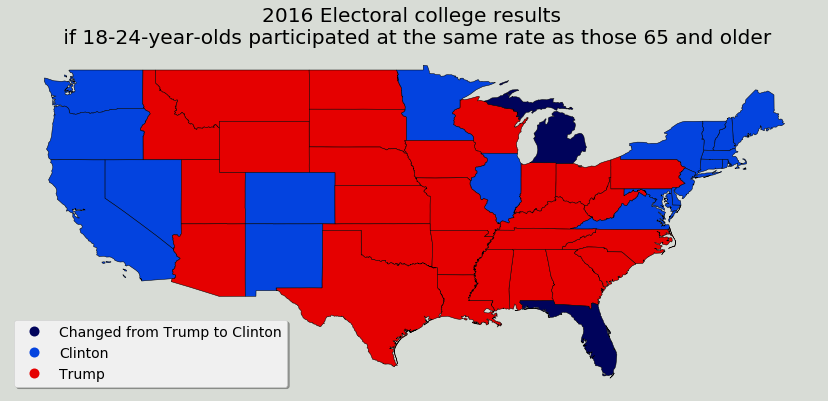

In [161]:
# Electoral map if 18-24s voted at the same rate as 65+ voters

fig, ax = plt.subplots(1, figsize=(13,6))
plt.style.use('fivethirtyeight')
fig.set_facecolor('xkcd:light grey')
ax.axis('off')
plt.title('2016 Electoral college results \n if 18-24-year-olds participated at the same rate as those 65 and older')
merged.plot(column='changemap',  categorical = True, cmap = cmap ,
                legend = True,  ax = ax, linewidth=.5, edgecolor='xkcd:black',
                legend_kwds={'loc': 'lower left', 'fontsize': 14,
                'shadow':True})
plt.savefig('map2.jpg', format='jpg', bbox_inches = 'tight')  
files.download('map2.jpg')
plt.show()

In [0]:
# Making a new dataframe with the map shape info and the results

merged_all = mapfile_df.set_index('STATE_ABBR').join(newresultallyouth.set_index('state_po'))

In [0]:
# Dropping Alaska and Hawaii for better looking maps

merged_all = merged_all.drop(['AK', 'HI'])

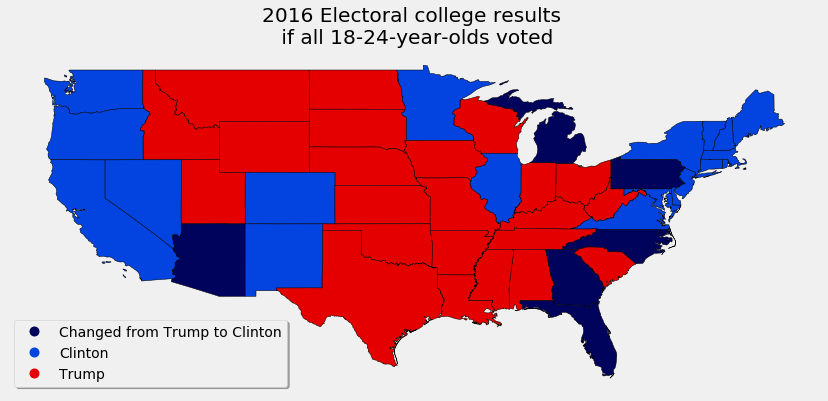

In [164]:
# Electoral map if all 18-24 voted

fig, ax1 = plt.subplots(1, figsize=(13, 7))
ax1.axis('off')
plt.title('2016 Electoral college results \n if all 18-24-year-olds voted')
merged_all.plot(column='changemap',categorical = True, cmap = cmap ,
                legend = True,  ax = ax1, linewidth=.5, edgecolor='xkcd:black',
                legend_kwds={'loc': 'lower left', 'fontsize': 14,
                'shadow':True})
plt.savefig('map1.jpg', format='jpg', bbox_inches = 'tight')  
files.download('map1.jpg')
plt.show()

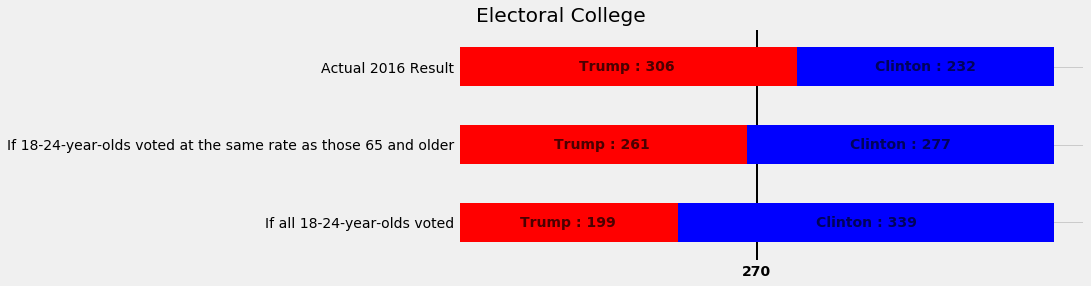

In [165]:
# Plot of the various election scenario results and the actual result

fig, ax = plt.subplots(1, figsize=(21, 9))

plt.title('Electoral College', ha='right', x =.3)
ax.yaxis.label.set_visible(False)
ax.set_xticks([269])
ax.set_xticklabels(['270'], {'fontweight':'bold'})
ax.xaxis.set_tick_params(grid_linewidth=2, grid_color='black')
electoral_results.plot.barh(stacked=True, legend = False, color='RB', ax=ax, figsize=(10,4))
ax.legend().set_visible(False)
ax.text(electoral_results.iloc[0,0]/2 , 0, str('Trump : 199'), va = 'center', ha= 'center', color='xkcd:dried blood', fontweight='bold')
ax.text(electoral_results.iloc[1,0]/2 , 1, str('Trump : 261'), va = 'center', ha= 'center', color='xkcd:dried blood', fontweight='bold')
ax.text(electoral_results.iloc[2,0]/2 , 2, str('Trump : 306'), va = 'center', ha= 'center', color='xkcd:dried blood', fontweight='bold')
ax.text( (electoral_results.iloc[2,0]+( electoral_results.iloc[2,1] /2)),2, str('Clinton : 232'), va = 'center', ha= 'center', color='xkcd:dark blue', fontweight='bold')
ax.text( (electoral_results.iloc[1,0]+( electoral_results.iloc[1,1] /2)),1, str('Clinton : 277'), va = 'center', ha= 'center', color='xkcd:dark blue', fontweight='bold')
ax.text( (electoral_results.iloc[0,0]+( electoral_results.iloc[0,1] /2)),0, str('Clinton : 339'), va = 'center', ha= 'center', color='xkcd:dark blue', fontweight='bold')

plt.savefig('barplot.jpg', format='jpg', bbox_inches = 'tight', dpi = 144)    
files.download('barplot.jpg')
plt.show()